In [1]:
# Import libraries
import math
import random
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, precision_recall_curve, auc, roc_curve, recall_score, classification_report 
from sklearn.model_selection import train_test_split
import sklearn
from sklearn import metrics
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
import scikitplot as skplt

# Got 90ish AUC score? Check your test set!
I want to discuss and illustrate a common problem some of the beginners face - target leak (I've been there myself as well). It appears that in this particular challenge it happens over and over again. So I think it'd be helpful to point out the most obvious mistake causing the leakage.<br>
Short version - you must have a clean separate test set put aside before you do upsampling/oversampling. Otherwise you soil your test set with synthetic data that your model just has learnt to predict very well. Hence the incredibly amazing score. <br>
I provide the example below.<br>
<a style = 'color : darkgray'>And just to be clear - I'm not doing any EDA here...</a>

Lets have a look at our data:

In [2]:
# data loading and hypermarameters setup
SEED = 1970
random.seed(SEED)

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
path = '../input/health-insurance-cross-sell-prediction/'
df_train = pd.read_csv(path + "train.csv").set_index('id')
df_train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [3]:
targets = df_train['Response'].value_counts()
print(targets)
print('Percentage of Positive class - %.0f'%(targets[1]/(targets.sum())*100), '%')

0    334399
1     46710
Name: Response, dtype: int64
Percentage of Positive class - 12 %


The major issue here is that we only have about 12% of the people who bought the insurance, 2 classes are really imbalanced. Therefore any model would have a tough time making confident prediction.<br>
In general we'd like to have evenly represented classes. Otherwise we'd need to upsample the minority class, or downsample the majority. There are different approches and techniques for achieving it. One of them is SMOTE, and I choose it here since it is really easy to use. But you might want to [check it later](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html#imblearn.over_sampling.SMOTE).

I'm encoding categorical features as labels (for simplicity I leave one-hot encoding out as it is not crucial for the problem at hands):

In [4]:
col_list = df_train.columns.to_list()[1:]
df_train_corr = df_train.copy()

categorical_features = ['Gender', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage','Policy_Sales_Channel']
text_features = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']

# encode text categorical features
le = preprocessing.LabelEncoder()
for f in text_features :
    df_train_corr[f] = le.fit_transform(df_train_corr[f])
for f in categorical_features :
    df_train_corr[f] = df_train_corr[f].astype('int32')

df_train_corr.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,1,44,1,28,0,2,1,40454.0,26,217,1
2,1,76,1,3,0,0,0,33536.0,26,183,0
3,1,47,1,28,0,2,1,38294.0,26,27,1
4,1,21,1,11,1,1,0,28619.0,152,203,0
5,0,29,1,41,1,1,0,27496.0,152,39,0


Lets put aside 10% of the samples as our final test set (and FYI this is that most crucial moment many are missing). Any <a style = ' color : brown'>Feature Engineering</a> must be done <a style = ' color : red'>before</a> this split by the way.

In [5]:
df_temp, X_test, y_temp, y_test = train_test_split(df_train_corr, df_train_corr['Response'], train_size=0.9, random_state = SEED)
X_test = X_test.drop(columns = ['Response'])

Now lets do upsampling using SMOTE:

In [6]:
ovrsmpl = SMOTE(n_jobs=-1, k_neighbors=5, random_state = SEED)
X_balanced, y_balanced = ovrsmpl.fit_resample(df_temp.drop(['Response'], axis=1), df_temp['Response'])
# sanity check
print(X_balanced.shape)
X_balanced.head()

(601966, 10)


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,1,55,1,28,0,0,1,2630.0,124,242
1,1,46,1,35,0,0,1,27112.0,26,229
2,1,40,1,7,0,0,1,2630.0,26,174
3,0,31,1,4,1,1,0,50165.0,152,38
4,1,66,1,28,0,0,1,33511.0,24,292


Lets check the results of the upsampling:

In [7]:
print('Number of duplicates in the original train set :',df_temp.duplicated().sum())
print('Original class distribution:')
print(y_temp.value_counts())
print('-'*40)
print('Number of duplicates in the oversampled train set :',X_balanced.duplicated().sum())
print('New class distribution:')
print(y_balanced.value_counts())

Number of duplicates in the original train set : 228
Original class distribution:
0    300983
1     42015
Name: Response, dtype: int64
----------------------------------------
Number of duplicates in the oversampled train set : 14221
New class distribution:
1    300983
0    300983
Name: Response, dtype: int64


There are quite a few duplicates produced (about 2.4%), and we might check later if they skew our results.<br>
And now lets split our newly **upsampled and balanced** data set into **train/validation sets**.

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X_balanced, y_balanced, train_size=0.9, random_state = SEED)

In [9]:
def plot_ROC(fpr, tpr, m_name):
    roc_auc = sklearn.metrics.auc(fpr, tpr)
    plt.figure(figsize=(6, 6))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)
    
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('Receiver operating characteristic for %s'%m_name, fontsize=20)
    plt.legend(loc="lower right", fontsize=16)
    plt.show()

We are ready to train a basic model, and make predictions on our validation sets.

In [10]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [11]:
def predict_display(df,target):
    rfc_preds_proba = rfc.predict_proba(df)
    rfc_pred = rfc.predict(df)
    rfc_preds_proba = rfc.predict_proba(df)
    rfc_score = roc_auc_score(target, rfc_preds_proba[:,1])
    (fpr, tpr, thresholds) = roc_curve(target, rfc_preds_proba[:,1])
    plot_ROC(fpr, tpr,'RandomForestClassifier')
    print('ROC AUC score for RandomForestClassifier model with over-sampling: %.4f'%rfc_score)
    print('F1 score: %0.4f'%f1_score(target, rfc_pred))
    print(f"Accuracy score is {100*accuracy_score(target,rfc_pred).round(2)}")
    skplt.metrics.plot_confusion_matrix(target, rfc_pred,figsize=(8,8))

Prepare to be <a style = 'font-weight: bold; color : red'>amazed</a> :)<br>
This Random Forest classifier with default settings will provide us with quite remarkable results with no efforts. And of course we can get it much better with tuning parameters, or using boosted trees, like XGBoost, for example. We can get to almost ***perfect 100%*** :)

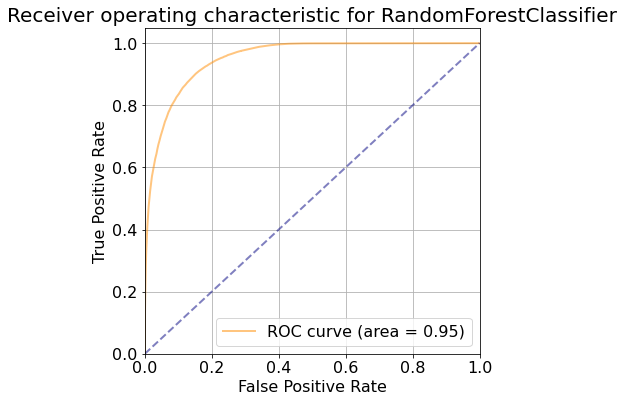

ROC AUC score for RandomForestClassifier model with over-sampling: 0.9508
F1 score: 0.8792
Accuracy score is 87.0


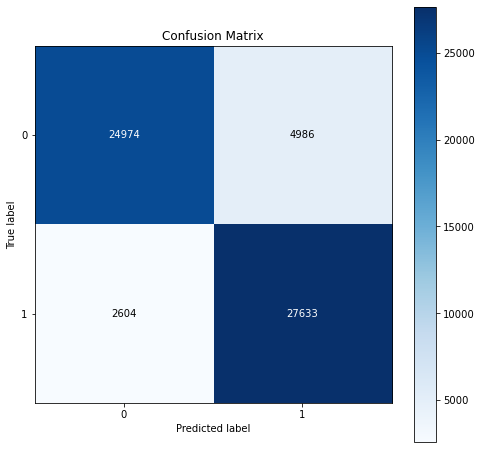

In [12]:
# doing prediction on the validation set we got AFTER oversampling
predict_display(X_valid, y_valid)

As you can see we got really decent and **balanced** prediction.<br>
<br>
However if we check the same model on the **preserved test set** that was not affected by the oversampling algorithm the result is drastically different.<br>
It is most apparent when you compare the confusion matrices - the model is not really capable of predicting <a style='color:red'>True Positives</a>, giving almost 50% <a style='color:red'>False Negatives</a> and significant number of <a style='color:red'>False Positives</a>. The score mostly defined by the prediction of <a style='color:red'>True Negatives</a> which is much more easier to do due to the class imbalance in the test set. And the **F1 score is just 40%** in this case.<br>
However I need to point out that the balancing classes by SMOTE has helped a lot because the same model trained on the original imbalanced dataset predicts almost no <a style='color:red'>True Positives</a>, giving **F1 score below 2%** as the result (I checked it when started working with this challenge).

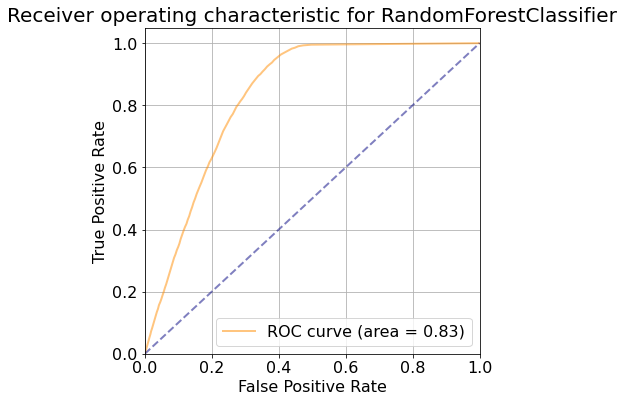

ROC AUC score for RandomForestClassifier model with over-sampling: 0.8291
F1 score: 0.3980
Accuracy score is 80.0


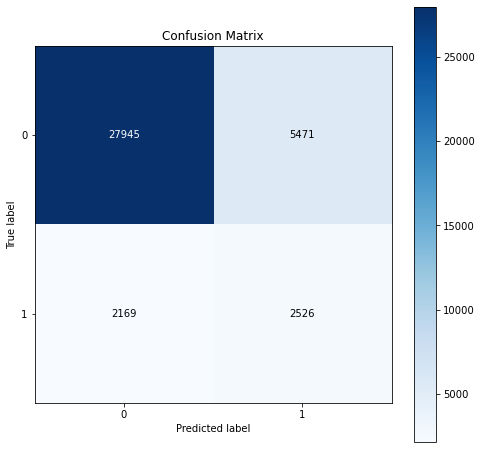

In [13]:
# doing prediction on the validation set we put aside BEFORE oversampling
predict_display(X_test, y_test)

This does not look as good, but it is a good starting point! <BR>
Knowing that oversampling helps us we can improve further by doing feature engineering, choosing different models with better perfomance, ensembling different models etc.

# Conclusion
So as you can see it is a very simple mistake that can easily be avoided - just take care of your validation/test set before doing any type of oversampling/upsampling.<br>
However keep in mind that there are more trickier ways to get the leakage, and I'd advise to learn about the issue, maybe starting with this [Kaggle tutorial 'Data Leakage'](https://www.kaggle.com/alexisbcook/data-leakage)

<p style = 'font-size : medium; font-weight: bold; color : brown'> Please Upvote this notebook if you found it useful. </p>